In [1]:
import sys 
import gymnasium as gym
from gymnasium.wrappers.record_video import RecordVideo
from gymnasium.wrappers.record_episode_statistics import RecordEpisodeStatistics
import kidspuzzles
from stable_baselines3 import A2C

n_digits = 2
# reward_clipped = -0.02
# reward_enter_target_area = 0.01
# reward_exit_target_area = -0.02

env = gym.make(
    'kidspuzzles/DigitsPuzzleEnv-v0', 
    render_mode = 'rgb_array', 
    n_digits = n_digits,
    # reward_clipped = reward_clipped,
    # reward_enter_target_area = reward_enter_target_area,
    # reward_exit_target_area = reward_exit_target_area
)

video_folder = f"DigitsPuzzle-{n_digits}"
record_freq = 200

env = RecordVideo(env, video_folder=f"videos/{video_folder}", name_prefix="training",
                  episode_trigger=lambda x: x % record_freq == 0)

model = A2C(
    "MultiInputPolicy", 
    env, 
    verbose=1, 
    device="mps", 
    tensorboard_log=f"./logs/a2c_digitspuzzle_nd{n_digits}/"
)
model.learn(total_timesteps=10_000)

Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/a2c_digitspuzzle_nd2/A2C_2
MoviePy - Building video /Users/bapa/Codes/KidsPuzzles/videos/DigitsPuzzle-2--0.02-0.01--0.02/training-episode-0.mp4.
MoviePy - Writing video /Users/bapa/Codes/KidsPuzzles/videos/DigitsPuzzle-2--0.02-0.01--0.02/training-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /Users/bapa/Codes/KidsPuzzles/videos/DigitsPuzzle-2--0.02-0.01--0.02/training-episode-0.mp4


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 157      |
|    ep_rew_mean        | -52.7    |
| time/                 |          |
|    fps                | 87       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -2.06    |
|    explained_variance | 0.0      |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -1.79    |
|    value_loss         | 0.927    |
------------------------------------
----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 142          |
|    ep_rew_mean        | -46          |
| time/                 |              |
|    fps                | 120          |
|    iterations         | 200          |
|    time_elapsed       | 8            |
|    total_timesteps    | 1000         |
| 

MoviePy - Done !
MoviePy - video ready /Users/bapa/Codes/KidsPuzzles/videos/DigitsPuzzle-2--0.02-0.01--0.02/training-episode-200.mp4


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 9.65      |
|    ep_rew_mean        | -0.822    |
| time/                 |           |
|    fps                | 171       |
|    iterations         | 1100      |
|    time_elapsed       | 31        |
|    total_timesteps    | 5500      |
| train/                |           |
|    entropy_loss       | -1.63     |
|    explained_variance | 0.5160639 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1099      |
|    policy_loss        | -0.192    |
|    value_loss         | 0.013     |
-------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 7.67       |
|    ep_rew_mean        | -0.45      |
| time/                 |            |
|    fps                | 173        |
|    iterations         | 1200       |
|    time_elapsed       | 34         |
|    total_timesteps    | 6000       |
| t

MoviePy - Done !
MoviePy - video ready /Users/bapa/Codes/KidsPuzzles/videos/DigitsPuzzle-2--0.02-0.01--0.02/training-episode-400.mp4


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 5.64      |
|    ep_rew_mean        | 0.024     |
| time/                 |           |
|    fps                | 175       |
|    iterations         | 1400      |
|    time_elapsed       | 39        |
|    total_timesteps    | 7000      |
| train/                |           |
|    entropy_loss       | -1.21     |
|    explained_variance | 0.2122261 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1399      |
|    policy_loss        | 0.186     |
|    value_loss         | 0.294     |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 4.42     |
|    ep_rew_mean        | 0.289    |
| time/                 |          |
|    fps                | 176      |
|    iterations         | 1500     |
|    time_elapsed       | 42       |
|    total_timesteps    | 7500     |
| train/             

MoviePy - Done !
MoviePy - video ready /Users/bapa/Codes/KidsPuzzles/videos/DigitsPuzzle-2--0.02-0.01--0.02/training-episode-600.mp4


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 4.7       |
|    ep_rew_mean        | 0.235     |
| time/                 |           |
|    fps                | 177       |
|    iterations         | 1600      |
|    time_elapsed       | 45        |
|    total_timesteps    | 8000      |
| train/                |           |
|    entropy_loss       | -1.03     |
|    explained_variance | 0.6649202 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1599      |
|    policy_loss        | 0.0428    |
|    value_loss         | 0.0313    |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 4.53      |
|    ep_rew_mean        | 0.276     |
| time/                 |           |
|    fps                | 177       |
|    iterations         | 1700      |
|    time_elapsed       | 47        |
|    total_timesteps    | 8500      |
| train/    

MoviePy - Done !
MoviePy - video ready /Users/bapa/Codes/KidsPuzzles/videos/DigitsPuzzle-2--0.02-0.01--0.02/training-episode-800.mp4


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 4.56      |
|    ep_rew_mean        | 0.242     |
| time/                 |           |
|    fps                | 177       |
|    iterations         | 1800      |
|    time_elapsed       | 50        |
|    total_timesteps    | 9000      |
| train/                |           |
|    entropy_loss       | -0.884    |
|    explained_variance | 0.9667167 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1799      |
|    policy_loss        | 0.0494    |
|    value_loss         | 0.0129    |
-------------------------------------
MoviePy - Building video /Users/bapa/Codes/KidsPuzzles/videos/DigitsPuzzle-2--0.02-0.01--0.02/training-episode-1000.mp4.
MoviePy - Writing video /Users/bapa/Codes/KidsPuzzles/videos/DigitsPuzzle-2--0.02-0.01--0.02/training-episode-1000.mp4



MoviePy - Done !
MoviePy - video ready /Users/bapa/Codes/KidsPuzzles/videos/DigitsPuzzle-2--0.02-0.01--0.02/training-episode-1000.mp4
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 4.13      |
|    ep_rew_mean        | 0.356     |
| time/                 |           |
|    fps                | 177       |
|    iterations         | 1900      |
|    time_elapsed       | 53        |
|    total_timesteps    | 9500      |
| train/                |           |
|    entropy_loss       | -0.723    |
|    explained_variance | 0.6444261 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1899      |
|    policy_loss        | 0.027     |
|    value_loss         | 0.0645    |
-------------------------------------


--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 4.16       |
|    ep_rew_mean        | 0.348      |
| time/                 |            |
|    fps                | 178        |
|    iterations         | 2000       |
|    time_elapsed       | 56         |
|    total_timesteps    | 10000      |
| train/                |            |
|    entropy_loss       | -0.658     |
|    explained_variance | 0.30437064 |
|    learning_rate      | 0.0007     |
|    n_updates          | 1999       |
|    policy_loss        | -0.297     |
|    value_loss         | 0.0441     |
--------------------------------------


/Users/bapa/miniconda3/envs/gym/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward_list to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_list` for environment variables or `env.get_wrapper_attr('reward_list')` that will search the reminding wrappers.
  logger.warn(


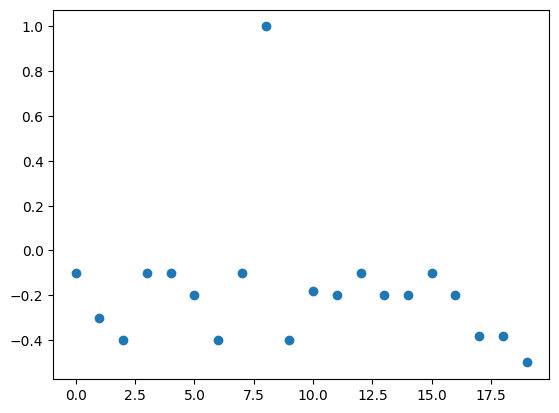

In [2]:
import matplotlib.pyplot as plt 
y = env.reward_list[::-500]
plt.scatter(range(len(y)), y)

In [3]:
import time
vec_env = model.get_env()
observations = vec_env.reset()
reward_sum = 0
for _ in range(50):
    action, _state = model.predict(observations)
    observations, reward, terminated, info = vec_env.step(action)
    vec_env.render("human")
    time.sleep(5)

    reward_sum += reward
    if terminated:
        observations = vec_env.reset()

print("Total reward: ", reward_sum)

2025-01-16 23:40:05.436 python[3887:126464] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-16 23:40:05.436 python[3887:126464] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Total reward:  [3.1999998]


In [4]:
env.close()